In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import scipy
import scipy.signal
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree
import elephant as el
import neo
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from matplotlib import mlab

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

16:15:36 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [4]:
output = pathlib.Path('output/stimulus-spike-lfp-response-reduced-transient-cut')
(output / 'data').mkdir(parents=True, exist_ok=True)

In [5]:
identify_neurons = actions['identify-neurons']
# sessions = pd.read_csv(identify_neurons.data_path('sessions'))
units = pd.read_csv(identify_neurons.data_path('units'))

In [6]:
def get_lim(action_id):
    stim_times = data_loader.stim_times(action_id)
    if stim_times is None:
        return [0, np.inf]
    stim_times = np.array(stim_times)
    return [stim_times.min(), stim_times.max()]

def get_mask(lfp, lim):
    return (lfp.times >= lim[0]) & (lfp.times <= lim[1])

def zscore(a):
    return (a - a.mean(0)) / a.std(0)

def compute_stim_freq(action_id):
    stim_times = data_loader.stim_times(action_id)
    if stim_times is None:
        return np.nan
    stim_times = np.array(stim_times)
    return 1 / np.mean(np.diff(stim_times))

In [7]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)

In [8]:
def compute_energy(p, f, f1, f2):
    if np.isnan(f1) or np.all(np.isnan(p)):
        return np.nan
    mask = (f > f1) & (f < f2)
    df = f[1] - f[0]
    return np.sum(p[mask]) * df

In [9]:
def find_theta_peak(p, f, f1, f2):
    if np.all(np.isnan(p)):
        return np.nan, np.nan
    mask = (f > f1) & (f < f2)
    p_m = p[mask]
    f_m = f[mask]
    peaks, _ = find_peaks(p_m)
    idx = np.argmax(p_m[peaks])
    return f_m[peaks[idx]], p_m[peaks[idx]]

In [10]:
def compute_half_width(p, f, m_p, m_f):
    if np.isnan(m_p):
        return np.nan, np.nan
    m_p_half = m_p / 2
    half_p = p - m_p_half
    idx_f = np.where(f <= m_f)[0].max()
    idxs_p1, = np.where(np.diff(half_p[:idx_f + 1] > 0) == 1)
    if len(idxs_p1) == 0:
        return np.nan, np.nan
    m1 = idxs_p1.max()
    idxs_p2, = np.where(np.diff(half_p[idx_f:] > 0) == 1)
    m2 = idxs_p2.min() + idx_f
    assert p[m1] < m_p_half < p[m1+1], (p[m1], m_p_half, p[m1+1])
    assert p[m2] > m_p_half > p[m2+1], (p[m2], m_p_half, p[m2+1])
    
    f1 = interp1d([half_p[m1], half_p[m1 + 1]], [f[m1], f[m1 + 1]])(0)
    f2 = interp1d([half_p[m2], half_p[m2 + 1]], [f[m2], f[m2 + 1]])(0)
    return f1, f2

In [11]:
# p = np.load('debug_p.npy')
# f = np.load('debug_f.npy')
# compute_half_width(p, f, 0.01038941, 30.30187709636872)

In [12]:
# plt.plot(f, p)
# plt.xlim(29.9,30.6)

In [13]:
def compute_stim_peak(p, f, s_f):
    if np.isnan(s_f):
        return np.nan
    return interp1d(f, p)(s_f)

In [14]:
def compute_spike_lfp_coherence(anas, sptr, NFFT):

    sigs, freqs = el.sta.spike_field_coherence(anas, sptr, **{'nperseg': NFFT})
    return sigs, freqs

In [15]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

# def compute_spike_phase_func(lfp, times, return_degrees=False):
#     x_a = hilbert(lfp)
#     x_phase = np.angle(x_a)
#     if return_degrees:
#         x_phase = x_phase * 180 / np.pi
#     return interp1d(times, x_phase)


def vonmises_kde(data, kappa=100, n_bins=100):
    from scipy.special import i0
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa * np.cos(x[:, None] - data[None, :])).sum(1) / (2 * np.pi * i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde


def spike_phase_score(phase_bins, density):
    import math
    import pycircstat as pc
    ang = pc.mean(phase_bins, w=density)
    vec_len = pc.resultant_vector_length(phase_bins, w=density)
    # ci_lim = pc.mean_ci_limits(head_angle_bins, w=rate)
    return ang, vec_len

In [16]:
def compute_clean_lfp(anas, width=50, threshold=2):
    anas = np.array(anas)
    idxs, = np.where(abs(anas) > threshold)
    for idx in idxs:
        anas[idx-width:idx+width] = 0 # TODO AR model prediction
    percentage_removed = len(idxs) * width * 2 / len(anas)
    return anas, idxs, percentage_removed


def compute_clean_spikes(spikes, idxs, times, width=50):

    for idx in idxs:
        t0 = times[idx-width]
        stop = idx + width
        if stop > len(times) - 1:
            stop = len(times) - 1 
        t1 = times[stop]
        mask = (spikes > t0) & (spikes < t1)
        spikes = spikes[~mask]
    spikes = spikes[spikes <= times[-1]]
    return spikes


def prepare_spike_lfp(anas, sptr, t_start, t_stop):

    t_start = t_start * pq.s if t_start is not None else 0 * pq.s
    sampling_rate = anas.sampling_rate
    units = anas.units
    times = anas.times
    if t_start is not None and t_stop is not None:
        t_stop = t_stop * pq.s
        mask = (times > t_start) & (times < t_stop)
        anas = np.array(anas)[mask,:]
        times = times[mask]
    
    # take best channel from other drive
    best_channel = np.argmax(signaltonoise(anas))
#     best_channel = np.random.choice(anas.shape[1])
    
    cleaned_anas, idxs, percentage_removed = compute_clean_lfp(anas[:, best_channel])
    cleaned_anas = neo.AnalogSignal(
        signal=cleaned_anas * units, sampling_rate=sampling_rate, t_start=t_start
    )
    
    spike_units = sptr.units
    spike_times = sptr.times
    spike_times = compute_clean_spikes(spike_times, idxs, times)

    sptr = neo.SpikeTrain(
        spike_times[(spike_times > t_start) & (spike_times < times[-1])], units=spike_units,
        t_start=t_start, t_stop=times[-1]
    )

    return cleaned_anas, sptr, best_channel, percentage_removed

In [17]:
def compute_spike_phase_func(lfp, times, return_degrees=False):
    from scipy.fftpack import next_fast_len
    x_a = scipy.signal.hilbert(
        lfp, next_fast_len(len(lfp)))[:len(lfp)]
#     x_a = hilbert(lfp)
    x_phase = np.angle(x_a, deg=return_degrees)
    return interp1d(times, x_phase)


def compute_spike_phase(lfp, spikes, flim=[6,10]):
    
    sample_rate = lfp.sampling_rate.magnitude
    
    # sometimes the position is recorded after LFP recording is ended
    times = np.arange(lfp.shape[0]) / sample_rate
     
    spikes = np.array(spikes)
    spikes = spikes[(spikes > times.min()) & (spikes < times.max())]
    
    filtered_lfp = butter_bandpass_filter(
        lfp.magnitude.ravel(), *flim, fs=sample_rate, order=3)

    spike_phase_func = compute_spike_phase_func(filtered_lfp, times)
    
    return spike_phase_func(spikes), filtered_lfp

(0, 100)

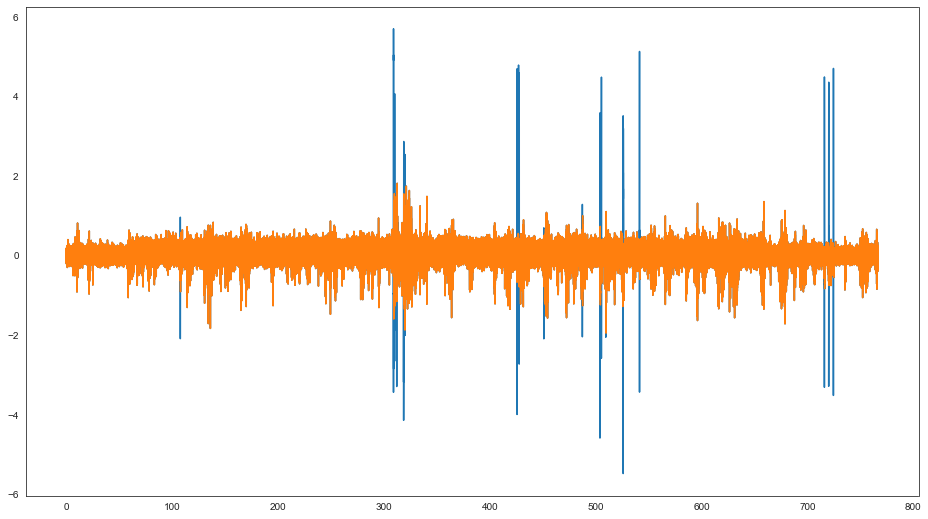

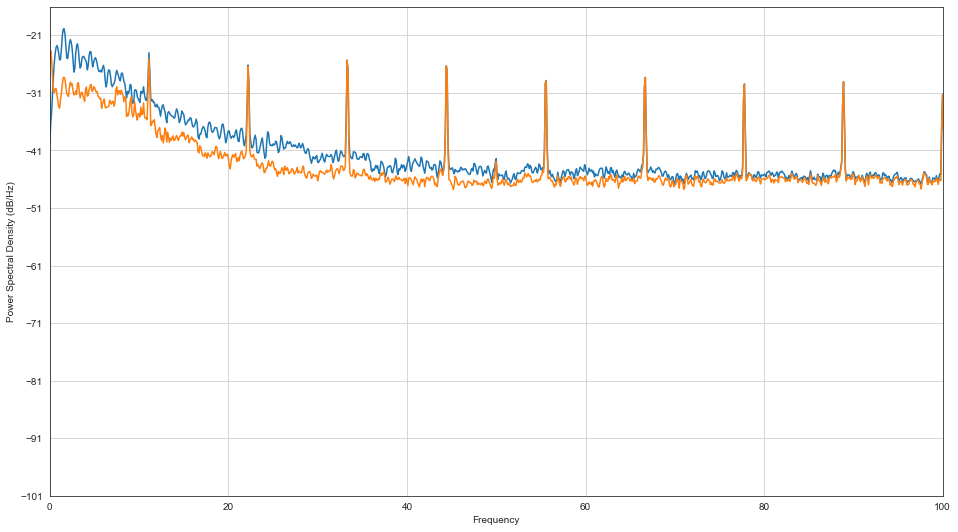

In [18]:
plt.figure(figsize=(16,9))
lfp = data_loader.lfp('1833-200619-2', 6)
# lfp = data_loader.lfp('1834-220319-3', 6)
# lfp = data_loader.lfp('1849-010319-4', 6)
times = np.arange(lfp.shape[0]) / lfp.sampling_rate.magnitude
clean_lfp, _, _ = compute_clean_lfp(lfp.magnitude[:, 0], threshold=2)
plt.plot(times,lfp[:,0])
plt.plot(times,clean_lfp)

plt.figure(figsize=(16,9))
plt.psd(lfp[:,0].ravel(), Fs=1000, NFFT=10000)
plt.psd(clean_lfp, Fs=1000, NFFT=10000)
plt.xlim(0,100)

In [19]:
# plt.figure(figsize=(16,9))

# plt.plot(times,lfp[:,0])
# # plt.plot(clean_lfp*100)
# plt.plot(times[:-1], np.diff(lfp[:,0].magnitude.ravel()))
# plt.xlim(64.5,65.5)
# # plt.ylim(-250,250)

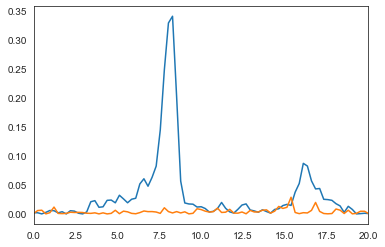

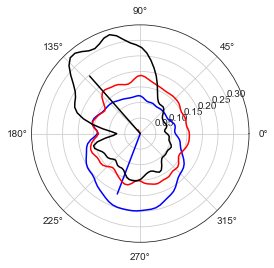

In [20]:
# action_id_0, channel_0, unit_0 = '1833-200619-1', 6, 163
# action_id_1, channel_1, unit_1 = '1833-200619-2', 6, 28
action_id_0, channel_0, unit_0 = '1834-220319-3', 2, 46
action_id_1, channel_1, unit_1 = '1834-220319-4', 2, 60

# change data loader to get all LFPs and then selecte the best form the other
lfp_0 = data_loader.lfp(action_id_0, channel_0)
lfp_1 = data_loader.lfp(action_id_1, channel_1)

sample_rate_0 = lfp_0.sampling_rate
sample_rate_1 = lfp_1.sampling_rate

lim_0 = get_lim(action_id_0)
lim_1 = get_lim(action_id_1)

sptrs_0 = data_loader.spike_trains(action_id_0, channel_0)

sptrs_1 = data_loader.spike_trains(action_id_1, channel_1)

cleaned_lfps_0, sptr_0, best_channel_0, percentage_removed_0 = prepare_spike_lfp(lfp_0, sptrs_0[unit_0], *lim_0)

cleaned_lfps_1, sptr_1, best_channel_1, percentage_removed_1 = prepare_spike_lfp(lfp_1, sptrs_1[unit_1], *lim_1)

coher_0, freq_0 = compute_spike_lfp_coherence(cleaned_lfps_0, sptr_0, 4096)

coher_1, freq_1 = compute_spike_lfp_coherence(cleaned_lfps_1, sptr_1, 4096)

spike_phase_0, filtered_lfp_0 = compute_spike_phase(cleaned_lfps_0, sptrs_0[unit_0], flim=[6,10])

spike_phase_1, filtered_lfp_1 = compute_spike_phase(cleaned_lfps_1, sptrs_1[unit_1], flim=[6,10])

# spike_phase_1_stim, filtered_lfp_1_stim = compute_spike_phase(cleaned_lfps_1, sptrs_1[unit_1], flim=[10.5,11.5])
spike_phase_1_stim, filtered_lfp_1_stim = compute_spike_phase(cleaned_lfps_1, sptrs_1[unit_1], flim=[29.5,30.5])

plt.figure()
plt.plot(freq_0, coher_0.ravel())
plt.plot(freq_1, coher_1.ravel())
plt.xlim(0,20)

plt.figure()
bins_0, kde_0 = vonmises_kde(spike_phase_0, 100)
ang_0, vec_len_0 = spike_phase_score(bins_0, kde_0)
plt.polar(bins_0, kde_0, color='b')
plt.polar([ang_0, ang_0], [0, vec_len_0], color='b')

bins_1, kde_1 = vonmises_kde(spike_phase_1, 100)
ang_1, vec_len_1 = spike_phase_score(bins_1, kde_1)
plt.polar(bins_1, kde_1, color='r')
plt.polar([ang_1, ang_1], [0, vec_len_1], color='r')

bins_1_stim, kde_1_stim = vonmises_kde(spike_phase_1_stim, 100)
ang_1_stim, vec_len_1_stim = spike_phase_score(bins_1_stim, kde_1_stim)
plt.polar(bins_1_stim, kde_1_stim, color='k')
plt.polar([ang_1_stim, ang_1_stim], [0, vec_len_1_stim], color='k')

In [21]:
percentage_removed_1

0.0

In [22]:
# TODO fix artefact stuff from phase precession

In [23]:
NFFT = 8192
theta_band_f1, theta_band_f2 = 6, 10 

In [24]:
coherence_data, freqency_data = {}, {}
theta_kde_data, theta_bins_data = {}, {}
stim_kde_data, stim_bins_data = {}, {}

def process(row):
    action_id = row['action']
    channel_group = row['channel_group']
    unit_name = row['unit_name']
    
    name = f'{action_id}_{channel_group}_{unit_name}'
    
    # select 
    lfp = data_loader.lfp(action_id, channel_group) # TODO consider choosing strongest stim response
    
    sptr = data_loader.spike_train(action_id, channel_group, unit_name)
       
    lim = get_lim(action_id)
    
    cleaned_lfp, sptr, best_channel, percentage_removed = prepare_spike_lfp(lfp, sptr, *lim)
       
    p_xys, freq = compute_spike_lfp_coherence(cleaned_lfp, sptr, NFFT=NFFT)
    
    p_xy = p_xys.magnitude.ravel()
    freq = freq.magnitude
    
    theta_f, theta_p_max = find_theta_peak(p_xy, freq, theta_band_f1, theta_band_f2)
    
    theta_energy = compute_energy(p_xy, freq, theta_band_f1, theta_band_f2) # theta band 6 - 10 Hz
    
    theta_half_f1, theta_half_f2 = compute_half_width(p_xy, freq, theta_p_max, theta_f)
    
    theta_half_width = theta_half_f2 - theta_half_f1
    
    theta_half_energy = compute_energy(p_xy, freq, theta_half_f1, theta_half_f2) # theta band 6 - 10 Hz
    
    theta_spike_phase, _ = compute_spike_phase(cleaned_lfp, sptr, flim=[theta_band_f1, theta_band_f2])
    theta_bins, theta_kde = vonmises_kde(theta_spike_phase)
    theta_ang, theta_vec_len = spike_phase_score(theta_bins, theta_kde)
    theta_kde_data.update({name: theta_kde})
    theta_bins_data.update({name: theta_bins})

    # stim
    
    stim_freq = compute_stim_freq(action_id)
    
    stim_p_max = compute_stim_peak(p_xy, freq, stim_freq)
    
    stim_half_f1, stim_half_f2 = compute_half_width(p_xy, freq, stim_p_max, stim_freq)
    stim_half_width = stim_half_f2 - stim_half_f1
    
    stim_energy = compute_energy(p_xy, freq, stim_half_f1, stim_half_f2)
    
    if np.isnan(stim_freq):
        stim_spike_phase, stim_bins, stim_kde, stim_ang, stim_vec_len = [np.nan] * 5
    else:
        stim_spike_phase, _ = compute_spike_phase(cleaned_lfp, sptr, flim=[stim_freq - .5, stim_freq + .5])
        stim_bins, stim_kde = vonmises_kde(stim_spike_phase)
        stim_ang, stim_vec_len = spike_phase_score(stim_bins, stim_kde)
        stim_kde_data.update({name: stim_kde})
        stim_bins_data.update({name: stim_bins})
        
    coherence_data.update({name: p_xy})
    freqency_data.update({name: freq})
    
    result = pd.Series({
        'percentage_removed': percentage_removed,
        'best_channel': best_channel,
        'theta_freq': theta_f,
        'theta_peak': theta_p_max,
        'theta_energy': theta_energy,
        'theta_half_f1': theta_half_f1, 
        'theta_half_f2': theta_half_f2,
        'theta_half_width': theta_half_width,
        'theta_half_energy': theta_half_energy,
        'theta_ang': theta_ang, 
        'theta_vec_len': theta_vec_len,
        'stim_freq': stim_freq,
        'stim_p_max': stim_p_max,
        'stim_half_f1': stim_half_f1, 
        'stim_half_f2': stim_half_f2,
        'stim_half_width': stim_half_width,
        'stim_energy': stim_energy,
        'stim_ang': stim_ang, 
        'stim_vec_len': stim_vec_len
    })
    return result

In [25]:
results = units.merge(
    units.progress_apply(process, axis=1), 
    left_index=True, right_index=True)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/signal/spectral.py:1577: RuntimeWarning: invalid value encountered in true_divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [26]:
pd.DataFrame(coherence_data).to_feather(output / 'data' / 'coherence.feather')
pd.DataFrame(freqency_data).to_feather(output / 'data' / 'freqs.feather')
pd.DataFrame(theta_kde_data).to_feather(output / 'data' / 'theta_kde.feather')
pd.DataFrame(theta_bins_data).to_feather(output / 'data' / 'theta_bins.feather')
pd.DataFrame(stim_kde_data).to_feather(output / 'data' / 'stim_kde.feather')
pd.DataFrame(stim_bins_data).to_feather(output / 'data' / 'stim_bins.feather')

# Save to expipe

In [27]:
action = project.require_action("stimulus-spike-lfp-response-reduced-transient-cut")

In [28]:
action.modules['parameters'] = {
    'NFFT': NFFT,
    'theta_band_f1': theta_band_f1,
    'theta_band_f2': theta_band_f2
}

In [29]:
action.data['results'] = 'results.csv'
results.to_csv(action.data_path('results'), index=False)

In [30]:
copy_tree(output, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-reduced-transient-cut/data/data/theta_kde.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-reduced-transient-cut/data/data/stim_kde.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-reduced-transient-cut/data/data/freqs.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-reduced-transient-cut/data/data/theta_bins.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-reduced-transient-cut/data/data/coherence.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-reduced-transient-cut/data/data/stim_bins.feather']

In [32]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-spike-lfp-response-reduced-transient-cut.ipynb")